<a href="https://colab.research.google.com/github/richardso21/GTAgency-OCR/blob/main/EAST_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying out EAST

## This works

[INFO] loading EAST text detector...
[INFO] text detection took 8.015953 seconds


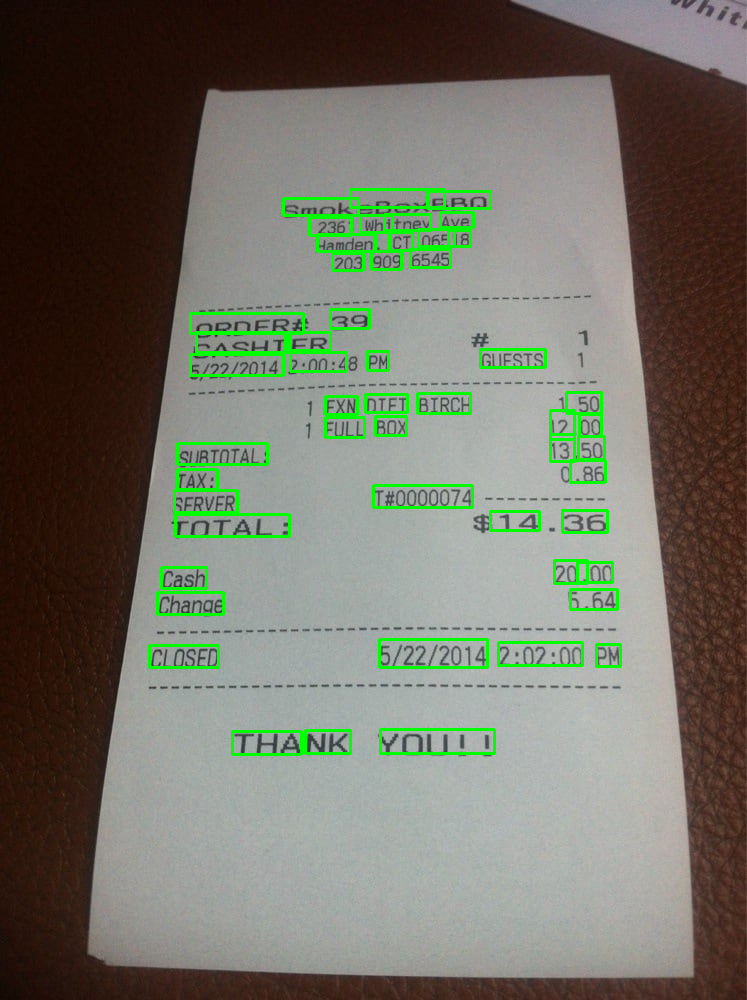

-1

In [45]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2

# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str,
# 	help="path to input image")
# ap.add_argument("-east", "--east", type=str,
# 	help="path to input EAST text detector")
# ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
# 	help="minimum probability required to inspect a region")
# ap.add_argument("-w", "--width", type=int, default=320,
# 	help="resized image width (should be multiple of 32)")
# ap.add_argument("-e", "--height", type=int, default=320,
# 	help="resized image height (should be multiple of 32)")
# args = vars(ap.parse_args())
args = {
    "image": "1075-receipt.jpg",
    "width": 1280,
    "height": 1280,
    "east": "./frozen_east_text_detection.pb",
    "min-confidence": 0.3
}

# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		#if scoresData[x] < args["min_confidence"]:
		if scoresData[x] < 0.3:
			continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(orig)
cv2.waitKey(0)

## Stuff that doesn't work

In [1]:
!pip install --upgrade imutils

In [2]:
from imutils.object_detection import non_max_suppression
import numpy as np
# import argparse
# import time
import cv2
from matplotlib import pyplot as plt
import os

In [3]:
rawImage = '1075-receipt.jpg'

In [25]:
image = cv2.imread(rawImage)

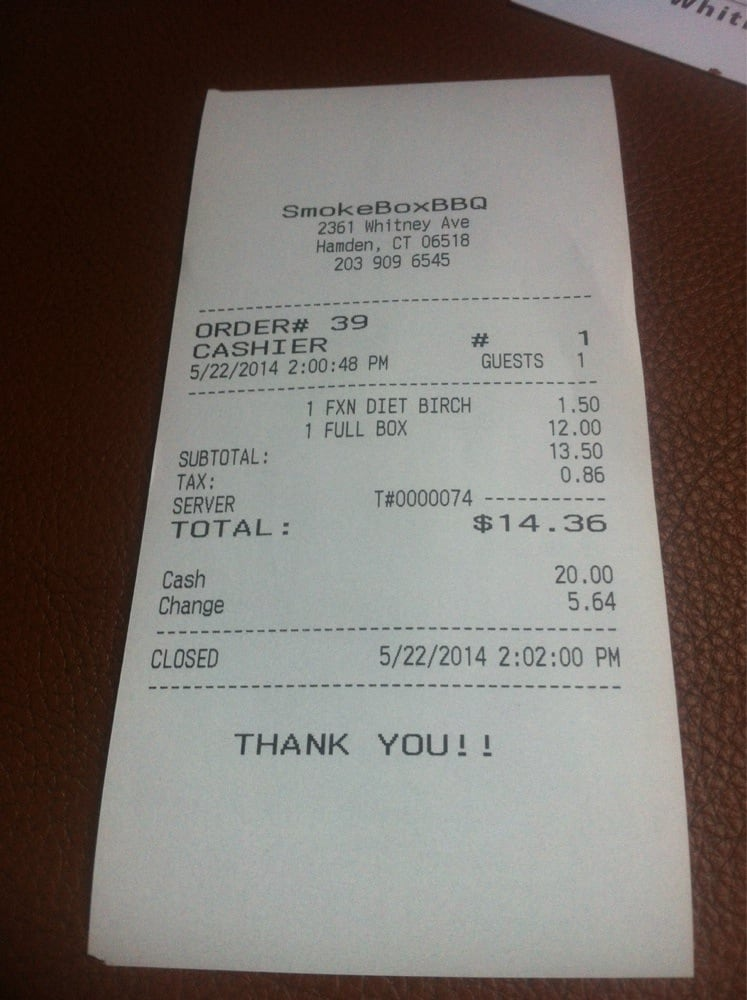

In [26]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [27]:
orig = image.copy()
(origH, origW) = image.shape[:2]

In [28]:
(newW, newH) = (640, 640)

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

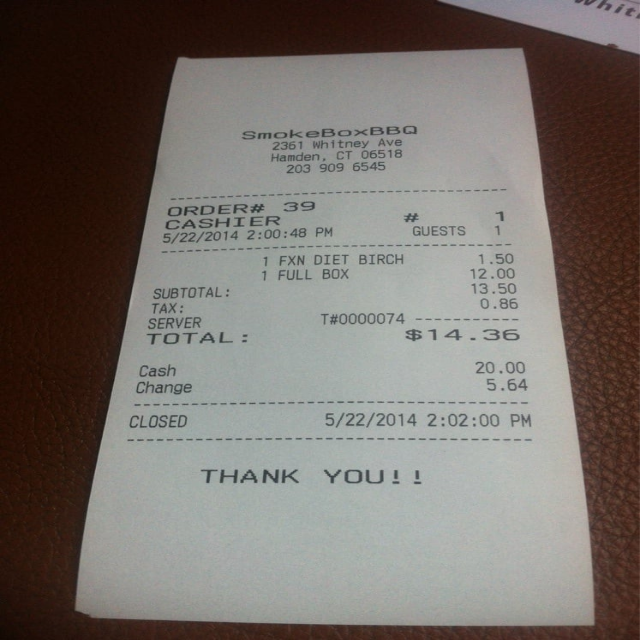

In [29]:
cv2_imshow(image)

In [30]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [31]:
# load the pre-trained EAST model for text detection 
net = cv2.dnn.readNet('./frozen_east_text_detection.pb')

# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
  
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [35]:
scores

array([[[[6.2380110e-08, 4.9260029e-07, 2.1826611e-06, ...,
          5.2659210e-09, 1.8848689e-10, 6.9628805e-07],
         [1.5214360e-08, 2.9456544e-09, 6.3348445e-08, ...,
          1.6915189e-08, 9.6394996e-11, 5.7638583e-09],
         [3.5798169e-09, 9.2490637e-10, 5.9627041e-08, ...,
          2.6391454e-03, 9.3908717e-08, 9.4153890e-08],
         ...,
         [9.0070614e-07, 2.0050409e-07, 5.9249066e-07, ...,
          7.6851131e-07, 6.8919672e-07, 6.1680576e-06],
         [5.3986213e-07, 4.4246153e-07, 7.7250132e-07, ...,
          1.6151509e-06, 1.2378317e-06, 5.5814098e-06],
         [7.1076903e-07, 6.6789433e-08, 6.9766671e-08, ...,
          7.1999835e-08, 3.4229043e-08, 3.7034710e-08]]]], dtype=float32)

In [33]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]


In [34]:
scoresData

array([7.10769029e-07, 6.67894327e-08, 6.97666707e-08, 3.83710663e-08,
       3.95986106e-08, 2.72701062e-08, 2.68779612e-08, 2.95902982e-08,
       3.69378519e-08, 5.47563097e-08, 6.00417636e-08, 6.14152285e-08,
       6.78330636e-08, 8.06976956e-08, 8.94198351e-08, 9.93267122e-08,
       1.22384776e-07, 1.67414839e-07, 1.72919030e-07, 1.75145317e-07,
       1.58117174e-07, 1.67342534e-07, 1.57797530e-07, 1.44115148e-07,
       1.21159147e-07, 1.13490707e-07, 1.12432822e-07, 1.01607533e-07,
       1.23554216e-07, 1.69159208e-07, 1.28473232e-07, 1.13980768e-07,
       1.36212748e-07, 1.68506787e-07, 1.58237256e-07, 1.65072578e-07,
       1.83234505e-07, 1.74088200e-07, 1.49026576e-07, 1.84061690e-07,
       2.25214265e-07, 2.24104880e-07, 2.12216477e-07, 2.41615936e-07,
       2.67020397e-07, 1.94819918e-07, 1.48197202e-07, 1.51117533e-07,
       1.61019400e-07, 1.28546887e-07, 1.02971860e-07, 9.76818413e-08,
       8.71011991e-08, 8.90075356e-08, 7.96619091e-08, 6.65927757e-08,
      

In [16]:
# loop over the number of columns

for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < 0.5:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

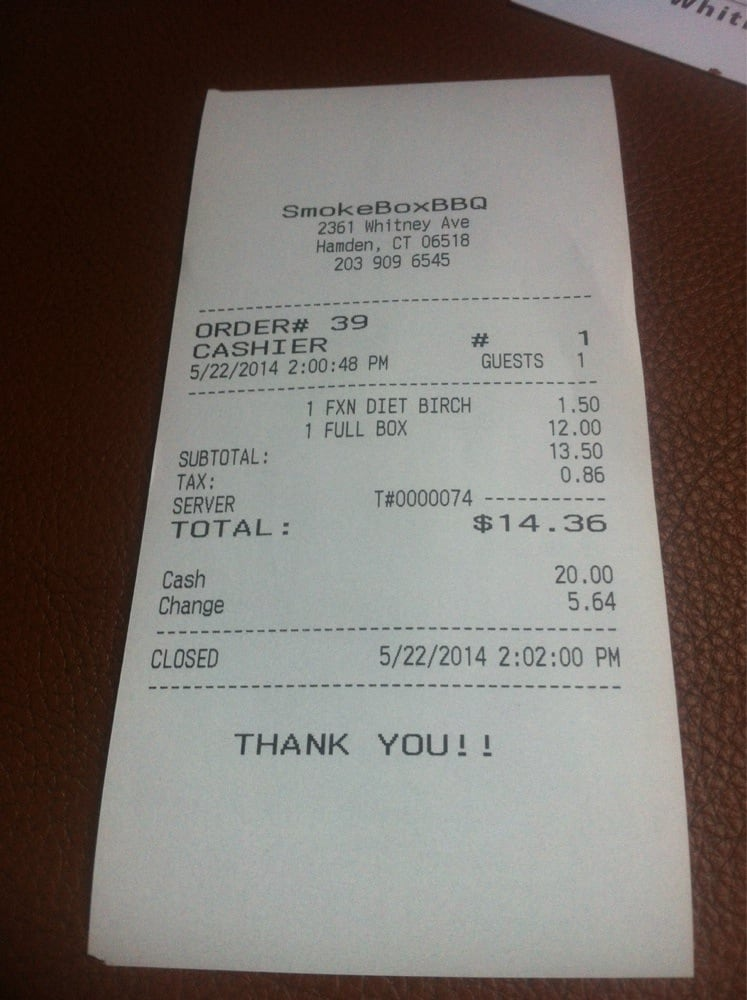

In [14]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(orig)

In [15]:
rects

[]